# Section 2.7 — Random variable generation

This notebook contains the code examples from [Section 2.7 Random variable generation]() of the **No Bullshit Guide to Statistics**.



#### Notebook setup

In [1]:
# load Python modules
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Figures setup
sns.set_theme(
    context="paper",
    style="whitegrid",
    palette="colorblind",
    rc={'figure.figsize': (7,4)},
)

%config InlineBackend.figure_format = 'retina'

# # silence annoying warnings
# import warnings; warnings.filterwarnings('ignore')

In [3]:
# set random seed for repeatability
random.seed(42)
np.random.seed(42)

## Synthetic data generation using simulation

In [4]:
import random

random.random()

0.6394267984578837

In [5]:
import numpy as np

np.random.rand(8)

array([0.37454012, 0.95071431, 0.73199394, 0.59865848, 0.15601864,
       0.15599452, 0.05808361, 0.86617615])

### Discrete random variable generation

In [6]:
def toss_coin(p=0.5):
    r = random.random()
    if r < p:
        return "heads"
    else:
        return "tails"

toss_coin(p=0.3)

'heads'

In [7]:
n = 1000
nflips = [toss_coin(p=0.3) for i in range(0,n)]
nflips.count("heads") / n

0.295

### Continuous random variable generation (optional)

#### Example: generating from the exponential distribution

<AxesSubplot:ylabel='Probability'>

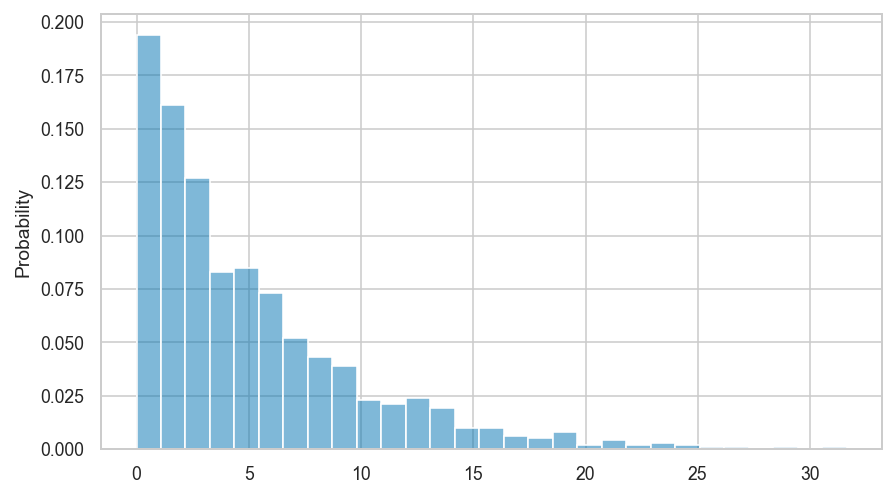

In [8]:
fig, ax = plt.subplots()

# manual random number generation
np.random.seed(6)
us = np.random.rand(1000)
lam = 0.2
es = -1 * np.log(1-us) / lam
sns.histplot(es, stat="probability", ax=ax, alpha=0.5)

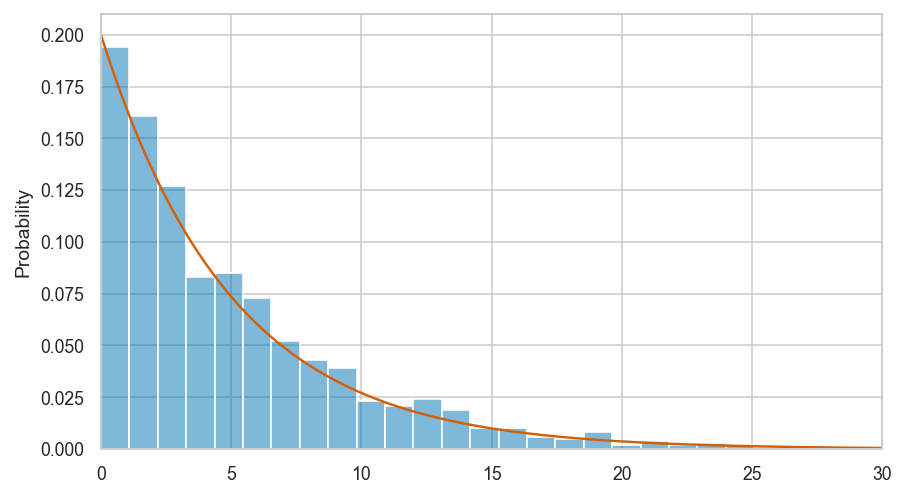

In [9]:
# theoretical probability density function
from scipy.stats import expon
rvE = expon(0,1/lam)
xs = np.linspace(0,35,1000)
fEs = rvE.pdf(xs)
sns.lineplot(x=xs, y=fEs, ax=ax, color="r")
ax.set_xlim([0,30])
fig

In [10]:
# filename = "figures/prob/generate_exp_and_pdf_rvE.pdf"
# basename = filename.replace('.pdf','').replace('.png','')
# with plt.rc_context({"figure.figsize":(4,2)}):
#     fig, ax = plt.subplots()
#     sns.histplot(es, stat="probability", ax=ax, alpha=0.5)
#     sns.lineplot(x=xs, y=fEs, ax=ax, color="r")
#     ax.set_xlim([0,30])
#     fig.tight_layout()
#     fig.savefig(basename + '.pdf', dpi=300, bbox_inches="tight", pad_inches=0.02)
#     fig.savefig(basename + '.png', dpi=300, bbox_inches="tight", pad_inches=0.02)

## Empirical distributions


Let's generate some random variable observations,
in order to be able to discuss.

In [11]:
from scipy.stats import norm

rvN = norm(1000,100)
ndata = rvN.rvs(1000)

<AxesSubplot:>

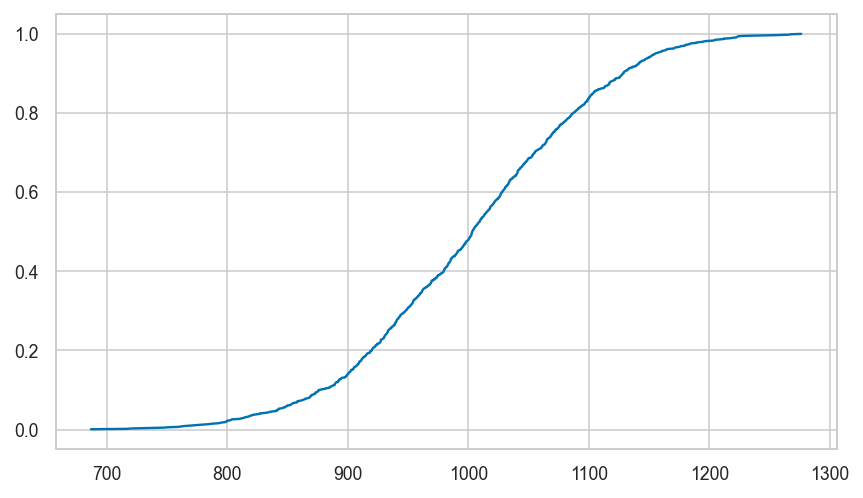

In [12]:
def ecdf(data):
    """
    Compute ECDF for on list of data observations.
    """
    n = len(data)
    xs = np.sort(data)
    ys = np.arange(1, n+1) / n
    return xs, ys

x1, y1 = ecdf(ndata)

sns.lineplot(x=x1, y=y1)

<AxesSubplot:>

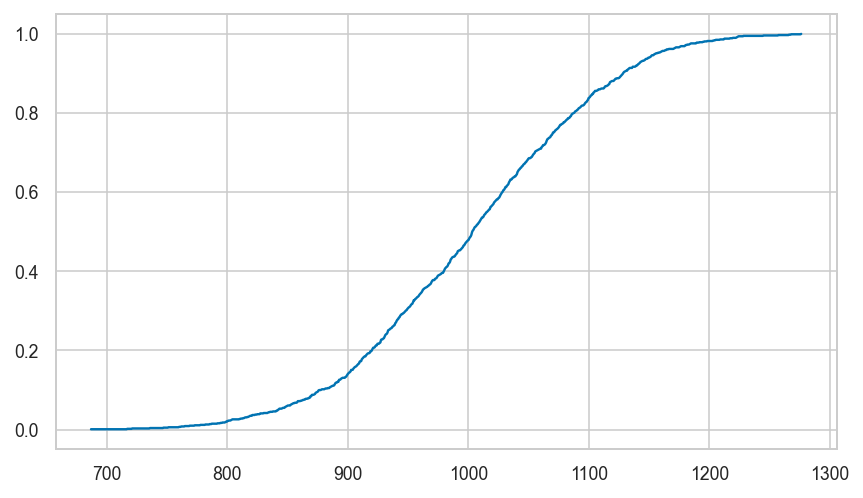

In [15]:
import statsmodels.api as sm

ecdf2 = sm.distributions.ECDF(ndata)

x2 = np.linspace(min(ndata),max(ndata),1000)
y2 = ecdf2(x2)
sns.lineplot(x=x2, y=y2)

## Measuring model-data fit

### Graphical methods

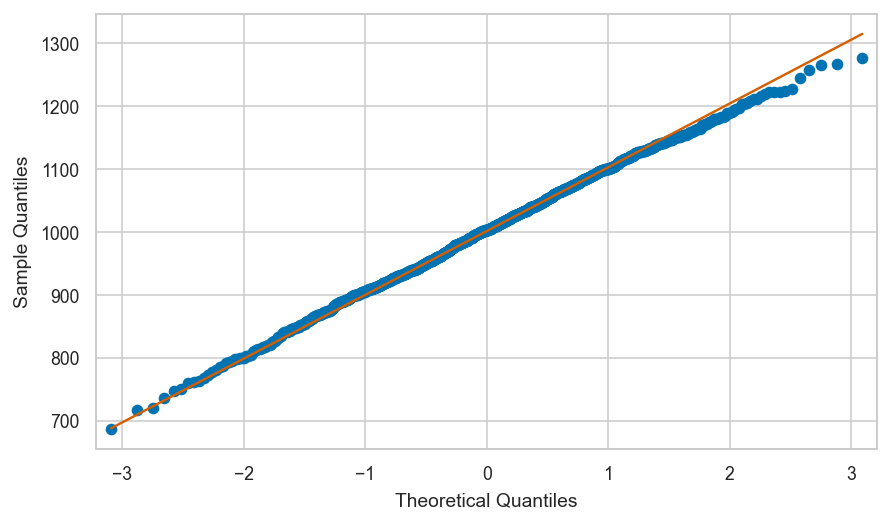

In [70]:
from statsmodels.graphics.api import qqplot

fig = qqplot(ndata, dist=norm(0,1), line='q')

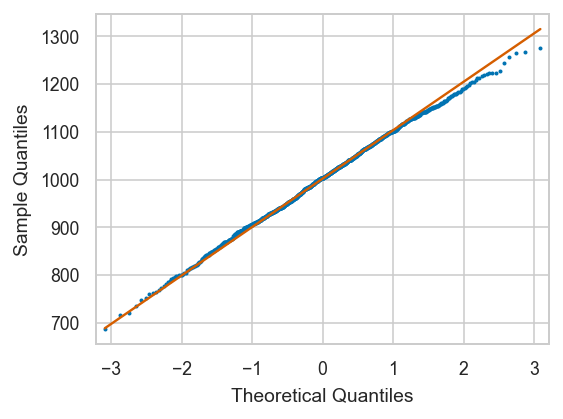

In [74]:
filename = "figures/prob/qqplot_ndata_vs_stdnorm.pdf"
basename = filename.replace('.pdf','').replace('.png','')
with plt.rc_context({"figure.figsize":(4,3)}):
    fig = qqplot(ndata, dist=norm(0,1), line='q', markersize=1)
    fig.tight_layout()
    fig.savefig(basename + '.pdf', dpi=300, bbox_inches="tight", pad_inches=0.02)
    fig.savefig(basename + '.png', dpi=300, bbox_inches="tight", pad_inches=0.02)

<AxesSubplot:>

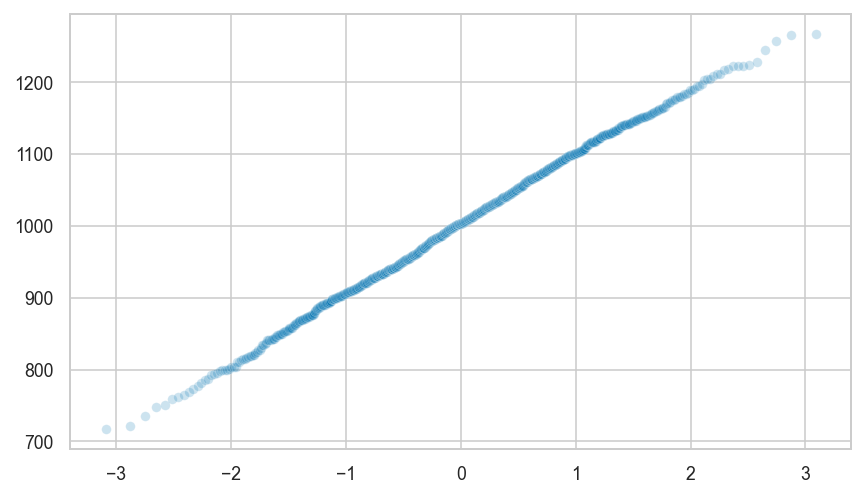

In [20]:
def qq_plot(data, model):
    """
    Prepares the values for a Q-Q plot.
    """
    ps = np.linspace(0, 1, 1000)
    q1 = model.ppf(ps)
    q2 = np.quantile(data, ps)
    ax = sns.scatterplot(x=q1, y=q2, alpha=0.2)
    return ax

qq_plot(ndata, norm(0,1))


# # ALT.
# plt.plot(q1, q2, ls="", marker="o")
# x = np.linspace(0,1) #np.min(data), np.max(data))
# plt.plot(x, x, color="k", ls="--")
# plt.show()

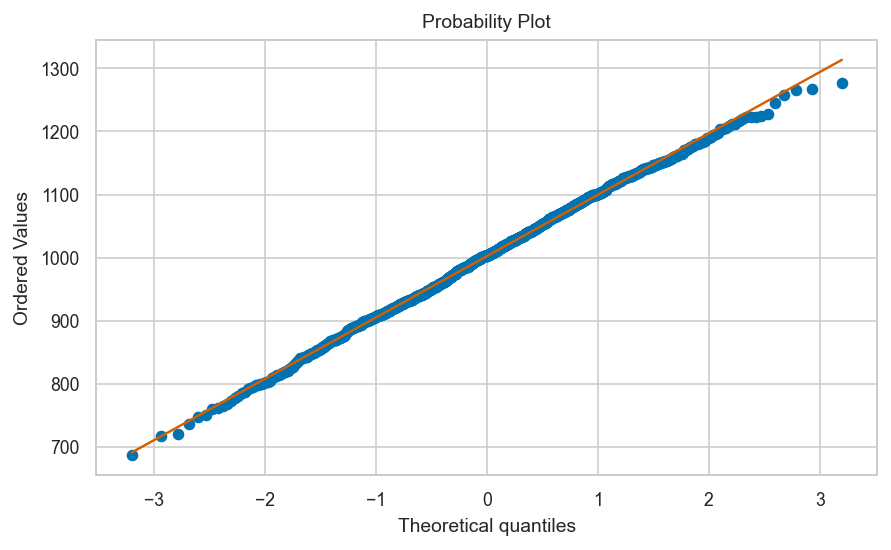

In [67]:
from scipy.stats import probplot

# _ = probplot(data, dist=rvN, plot=plt)
_ = probplot(ndata, dist=norm, plot=plt)

### Compare moments

### Kolmogorov–Smirnov test

In [58]:
def standardize(data):
    xbar = ndata.mean()
    s = ndata.std(ddof=1)
    return (data-xbar)/s


In [48]:
from scipy.stats import kstest

result = kstest(ndata, norm(1000,100).cdf, mode="exact")
result.statistic, result.pvalue

(0.02253916591963606, 0.68119682096187)

In [61]:
result = kstest(standardize(ndata), norm(0,1).cdf, mode="exact")
result.statistic, result.pvalue

(0.015903397481352333, 0.9585606795507295)

In [51]:
from scipy.stats import norm
from scipy.stats import kstwo

def eCDF(data, b):
    data.sort()               # sort the data
    count = sum(data <= b)    # counts # obs. <= b
    return count / len(data)  # proportion of total

def ks_norm(sample, dist=norm(0,1)):
    # Sorts the sample
    sample.sort()
    # Evaluates the KS statistic
    D_ks = [] # KS Statistic list
    for x in sample:
        cdf_normal = dist.cdf(x)
        eCDF_sample = eCDF(sample, b = x)
        D_k = abs(cdf_normal - eCDF_sample)
        D_ks.append(D_k)
    ks_stat = max(D_ks)
    # Calculates the P-Value based on the two-sided test
    # The P-Value comes from the KS Distribution Survival Function (SF = 1-CDF)
    p_value = kstwo.sf(ks_stat, len(sample))
    return {"ks_stat": ks_stat, "p_value" : p_value}

ks_norm(ndata, dist=norm(1000,100))

{'ks_stat': 0.02153916591963606, 'p_value': 0.733883624144605}

In [64]:

ks_norm(standardize(ndata), dist=norm(0,1))

{'ks_stat': 0.015903397481352333, 'p_value': 0.9585606795507295}

In [63]:
from statsmodels.stats.diagnostic import kstest_normal

kstest_normal(ndata, pvalmethod="approx")

(0.015903397481352333, 0.8390042586735309)

## Resampling methods

## Discussion